## Weakly Supervised Localization : Class Activation map for mnist
간단한 CNN (Global Average Pooling)을 mnist 데이터에 대해서 학습하고 임의의 mnist 데이터 중 하나를 예측하고 Class Activation Map을 그리는 예제,  
**최성준 박사과정**의 아래의 코드를 참고하였음.  

구조 : Conv-Conv-Max_pool-Conv-Conv-Global_average_pool-fully_connected  
참고 코드 : https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/gap_mnist.ipynb  
논문 : http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

### Load modules

In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
tf.set_random_seed(777)
mnist = input_data.read_data_sets(train_dir = './MNIST_data/', one_hot = True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


### Define CNN

In [3]:
# Graph parameters
weights = {
    
    'w1' : tf.get_variable(name = 'weight1', shape = [3,3,1,32], initializer = tf.contrib.layers.variance_scaling_initializer()), 
    'w2' : tf.get_variable(name = 'weight2', shape = [3,3,32,64], initializer = tf.contrib.layers.variance_scaling_initializer()),
    'w3' : tf.get_variable(name = 'weight3', shape = [3,3,64,96], initializer = tf.contrib.layers.variance_scaling_initializer()),
    'w4' : tf.get_variable(name = 'weight4', shape = [3,3,96,128], initializer = tf.contrib.layers.variance_scaling_initializer()),
    'w5' : tf.get_variable(name = 'weight5', shape = [128, 10], initializer = tf.contrib.layers.xavier_initializer())
}

bias = {
    'b1' : tf.get_variable(name = 'bias1', shape = [32], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b2' : tf.get_variable(name = 'bias2', shape = [64], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b3' : tf.get_variable(name = 'bias3', shape = [96], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b4' : tf.get_variable(name = 'bias4', shape = [128], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b5' : tf.get_variable(name = 'bias5', shape = [10], initializer = tf.random_normal_initializer())
}

In [4]:
def my_CNN(X, Y, weights, bias):
    Ximg = tf.reshape(tensor = X, shape = [-1, 28, 28 , 1])
    #conv_1
    conv1 = tf.nn.conv2d(input = Ximg, filter = weights['w1'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation1 = conv1 + bias['b1']
    print(pre_activation1)
    relu1 = tf.nn.relu(features = pre_activation1)

    #conv_2
    conv2 = tf.nn.conv2d(input = relu1, filter = weights['w2'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation2 = conv2 + bias['b2']
    print(pre_activation2)
    relu2 = tf.nn.relu(features = pre_activation2)

    #Max_pool
    pooled = tf.nn.max_pool(value = relu2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    #conv_3
    conv3 = tf.nn.conv2d(input = pooled, filter = weights['w3'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation3 = conv3 + bias['b3']
    print(pre_activation3)
    relu3 = tf.nn.relu(features = pre_activation3)
    
    #conv_4
    conv4 = tf.nn.conv2d(input = relu3, filter = weights['w4'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation4 = conv4 + bias['b4']
    print(pre_activation4)
    relu4 = tf.nn.relu(features = pre_activation4)

    #GAP
    gap = tf.nn.avg_pool(value = relu4, ksize = [1,14,14,1], strides = [1,14,14,1], padding = 'SAME')
    print(gap)
    gap_dense = tf.reshape(tensor = gap, shape = [-1,128])
    print(gap_dense)

    #fully_connected
    score = tf.matmul(gap_dense, weights['w5']) + bias['b5']
    print(score)
    
    out = {
        'Ximg' : Ximg, 'conv1' : relu1, 'conv2' : relu2, 'Max_pool' : pooled, 'conv3' : relu3, 'conv4' : relu4,
        'gap' : gap, 'gap_dense' : gap_dense, 'score' : score
    }
    
    return out
   
# define function    
X = tf.placeholder(dtype = tf.float32, shape = [None, 784])
Y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
out = my_CNN(X, Y, weights, bias)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = out['score']))
train = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
is_correct = tf.cast(tf.equal(tf.argmax(out['score'], axis = 1), tf.argmax(Y, axis = 1)), dtype = tf.float32)
accuracy = tf.reduce_mean(is_correct)

Tensor("add:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("add_1:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("add_2:0", shape=(?, 14, 14, 96), dtype=float32)
Tensor("add_3:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("AvgPool:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 128), dtype=float32)
Tensor("add_4:0", shape=(?, 10), dtype=float32)


### Training 

In [5]:
# hyperparameter
batch_size = 100
epochs = 10

# train
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size = batch_size)
        tr_loss, _ = sess.run([loss, train], feed_dict = {X : batch_xs, Y : batch_ys})
        val_loss = sess.run(loss, feed_dict = {X: mnist.validation.images, Y : mnist.validation.labels})
        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
        
    print('epoch : {:2}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))

epoch :  0, tr_loss : 0.888, val_loss : 0.867
epoch :  1, tr_loss : 0.161, val_loss : 0.152
epoch :  2, tr_loss : 0.106, val_loss : 0.101
epoch :  3, tr_loss : 0.082, val_loss : 0.079
epoch :  4, tr_loss : 0.064, val_loss : 0.064
epoch :  5, tr_loss : 0.056, val_loss : 0.055
epoch :  6, tr_loss : 0.048, val_loss : 0.049
epoch :  7, tr_loss : 0.041, val_loss : 0.044
epoch :  8, tr_loss : 0.038, val_loss : 0.039
epoch :  9, tr_loss : 0.034, val_loss : 0.037


In [6]:
# test accuracy
sess.run(accuracy, feed_dict = {X : mnist.test.images, Y : mnist.test.labels})

0.98940015

### Class Activation Map

In [7]:
# Class Activation Map
num = np.random.randint(0, mnist.test.labels.shape[0])
out = sess.run(my_CNN(X, Y, weights, bias), feed_dict = {X : mnist.test.images[num].reshape(1,784)})

Tensor("add_5:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("add_6:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("add_7:0", shape=(?, 14, 14, 96), dtype=float32)
Tensor("add_8:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("AvgPool_1:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("Reshape_6:0", shape=(?, 128), dtype=float32)
Tensor("add_9:0", shape=(?, 10), dtype=float32)


In [8]:
# Run Network 
inputimg = out.get('Ximg')
outval = out.get('score')
outprob = sess.run(tf.nn.softmax(outval))
camval = out.get('conv4')
cweights = sess.run(weights['w5'])

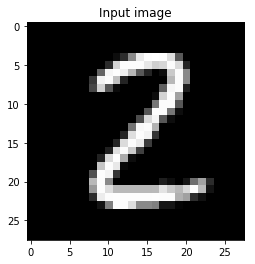

In [9]:
# Plot original Image 
plt.imshow(inputimg.reshape(28,28), cmap = 'gray')
plt.title("Input image")

In [10]:
# normalization function for Class Activation MAP
def minmax_scaler(arr):
    _arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return _arr    

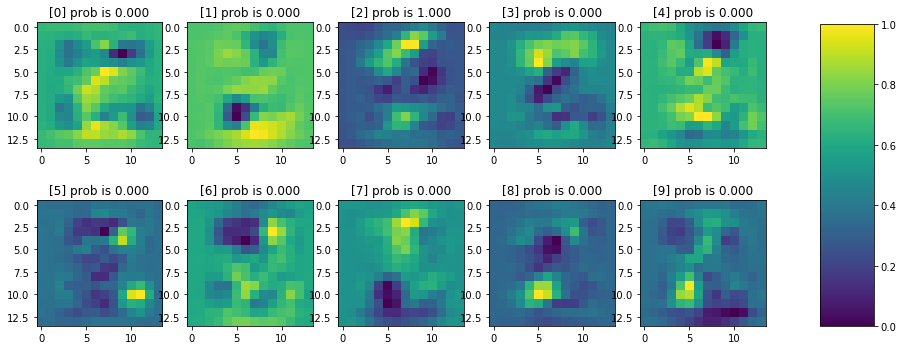

In [11]:
# Plot class activation maps 
fig, axs = plt.subplots(2, 5, figsize=(15, 6))    
for i in range(10):
    predlabel   = np.argmax(outval)
    predweights = cweights[:, i:i+1]
    camsum = np.zeros((14, 14))
    for j in range(128):
        camsum = camsum + predweights[j] * camval[0,:,:,j]
    camavg = camsum / 128
    # Plot 
    im = axs[int(i/5)][i%5].imshow(minmax_scaler(camavg))
    axs[int(i/5)][i%5].set_title(("[%d] prob is %.3f") % (i, outprob[0, i]))
    plt.draw()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)